# DLIM Lab 2: Embeddings and metric learning
Author: J. Chazalon  
Revision: 20230927-1030


# Introduction


## Context and references
Face verification, i.e. the process of automatically deciding whether two pictures of a face represent the same identity, is an interesting machine learning problem as an introduction to few-shots learning. Also, many databases are available, making the problem suitable for an in-class study.

We adapted here the Verification Subset of the Cross-Age Celebrity Dataset from Chen et. al (see references below) to ease its use, separate training, validation and test sets, and shuffle the test set.

Reference publications:

> Bor-Chun Chen, Chu-Song Chen, Winston H. Hsu. Cross-Age Reference Coding for Age-Invariant Face Recognition and Retrieval, ECCV 2014

> Bor-Chun Chen, Chu-Song Chen, Winston H. Hsu. Face Recognition using Cross-Age Reference Coding with Cross-Age Celebrity Dataset, IEEE Transactions on Multimedia, 2015.

For the code, we based our work on the great [facenet-pytorch](https://github.com/timesler/facenet-pytorch) project.


## Goal
Your goal is to produce a system which takes as input two images (pictures of faces) and returns a decision telling whether these two images represent the same person (aka "identity") or not.

## Dataset format
This adapted dataset is split into 3 subsets:

- `train/` directory: training set containing 3200 images pairs
- `val/` directory: validation set containing 400 images pairs
- `test/` directory: test set containing 400 images pairs

Each subset as an equal number of positive (same identity) and negative (different identities) pairs.

For each set the naming of the images have the following format: `NNNN_P.jpg` where

- `NNNN` is a 4 digits number representing the pair ID within the current subset
- `P` $\in \{0, 1\}$ is the image ID (left or right image)

**For the training and validation sets**, every two pairs is positive, and the other negative, i.e.:

- if `NNNN` is even, then the pair is a positive example (same identity)
- if `NNNN` is odd, then the pair is a negative example (different identities)

For the test set only, pair IDs were randomized. For teachers, we made available a separate file named `CACD_VS_cropped_test_targets.npy` which contains a table mapping pair IDs to a boolean value indicating whether the current pair is positive or negative.


In [1]:
!ls


## Image preprocessing and loading
All images were produced by cropping the original dataset images using an implementation of MTCNN, and the images were aligned using landmarks and resized to the shape `(160, 160, 3)`. Each image is saved as an RGB JPEG image.

When loading the images, appropriate preprocessing / normalization should be applied.
The [facenet-pytorch](https://github.com/timesler/facenet-pytorch) implementation we used simply applies the following transforms sequentially:

- convert to float32
- convert to Tensor
- center: `(image_tensor - 127.5) / 128.0`



## Dataset license
This adapted dataset version is for internal use only, and must not be redistributed.

# Installation and imports

In [6]:
!pip install facenet-pytorch opencv-python-headless numpy matplotlib scikit-learn torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━

In [61]:
pip install expecttest

Note: you may need to restart the kernel to use updated packages.


# Dataset loading
We provide you with tools to download and load the dataset easily and efficiently. You will have to understand how they work.

#### ❓ Question
The `CACDVSPairs` class below defines a dataset object. It contains 3 important methods:
- `__init__`
- `__getitem__ `
- `__len__`

**What is the use of each of these functions?**

*Write your anwser here.*

In [7]:
import os
from typing import Any, Callable, Dict, List, Optional, Tuple
from PIL import Image
from torchvision.datasets.utils import check_integrity, download_and_extract_archive, verify_str_arg
from torchvision.datasets.vision import VisionDataset
import numpy as np

class CACDVSPairs(VisionDataset):
    """ CACD VS Dataset

    Args:
        root (string): Root directory of dataset where directory
            ``cacd-vs-cropped`` exists or will be saved to if download is set to True.
        split (string, optional): The image split to use. Can be one of ``train``, ``val``, ``test``.
            Defaults to ``train``.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomRotation``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """

    base_folder = "cacd-vs-cropped"
    archive_download_url_prefix = "https://www.lrde.epita.fr/~jchazalo/SHARE/"
    archive_filename = "CACD_VS_cropped_student.tar.gz"
    archive_checksum = "8765744ccc3a015a5bdddfd705f779ac"

    splits_info: Dict[str, int] = {"train": 3200, "val": 400, "test": 400}

    def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
        test_targets: str = None,
    ) -> None:
        super().__init__(os.path.join(root, self.base_folder), transform=transform, target_transform=target_transform)

        self.split = verify_str_arg(split.lower(), "split", self.splits_info.keys())

        self.data: List[Tuple[str, str]] = []  # list of pairs of image paths
        self.targets: "np.array[bool]" | None = None  # pair_id -> True for positive cases, False otherwise

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError("Dataset not found or corrupted. You can use download=True to download it")

        # Load targets
        if self.split in ("train", "val"):
            # for train and val splits, even pair IDs are for positive cases, and odd for negative ones
            self.targets = np.arange(self.splits_info[self.split]) % 2 == 0
        else: # test set
            if test_targets is not None:
                if not check_integrity(test_targets, "fa16b248c8a67f6a4d6b8bd6363ef6eb"):
                    raise ValueError(f"'{test_targets}' file detected as corrupted. Not loading.")
                test_targets = np.load(test_targets)
            else:
                print("No targets provided for test set, using default values.")
                test_targets = np.zeros(400, dtype=bool)
            self.targets = test_targets

        # Load data (paths)
        for pair_id in range(self.splits_info[self.split]):
            self.data.append([self._get_path(self.split, pair_id, image_id) for image_id in range(2)])

    def __getitem__(self, index: int) -> Tuple[Any, Any, bool]:
        """
        Args:
            index (int): Index

        Returns:
            tuple (tuple: (image1, image2), target) where target is `False` for different indentities and `True` for same identities.
        """
        img1, img2 = self.data[index]
        img1, img2 = self._loader(img1), self._loader(img2)
        target = self.targets[index]

        if self.transform is not None:
            img1, img2 = self.transform(img1), self.transform(img2)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return (img1, img2), target


    def _loader(self, path: str) -> Image.Image:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")

    def _check_integrity(self) -> bool:
        # We do not check file integrity here, only paths
        for split, split_len in self.splits_info.items():
            for pair_id in range(split_len):
                for image_id in range(2):
                    file_path = self._get_path(split, pair_id, image_id)
                    if not os.path.exists(file_path):
                        print(f"Cannot locate {file_path}")
                        return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return
        url = f"{self.archive_download_url_prefix}{self.archive_filename}"
        download_and_extract_archive(url, self.root, filename=self.archive_filename, md5=self.archive_checksum)

    def _get_path(self, subset:str, pair_id: int, image_id) -> str:
        return os.path.join(self.root, subset, f"{pair_id:04d}_{image_id}.jpg")

    def __len__(self) -> int:
        return len(self.data)

Let us now now create this dataset object and observe the elements it contains.

In [8]:
from facenet_pytorch import fixed_image_standardization
from torchvision import transforms

# Ensure we get clean, normalized tensors for each image
transform = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

# We can ask for the "train", "val" and "test" splits.
dataset_train = CACDVSPairs("/content/datasets", split="train", download=True, transform=transform)

Cannot locate /content/datasets/cacd-vs-cropped/train/0000_0.jpg


100%|██████████| 28616272/28616272 [00:05<00:00, 4931717.70it/s]


Extracting /content/datasets/cacd-vs-cropped/CACD_VS_cropped_student.tar.gz to /content/datasets/cacd-vs-cropped


#### ❓ Question
Update the code of the cell below to display some useful properties of an item extracted from the dataset.

**What is its structure? What are the shapes and data types of the tensors it contains?**


*Write your anwser here.*

In [9]:
item0 = dataset_train[0]
item0[1]

True

We can also try to display the images!

This requires to:
- create a view of it where channels are ordered last, instead of first in PyTorch (use the `.permute(1, 2, 0)` method)
- copy the tensor to the CPU memory, if it is not already here (use the `.cpu()` or `.to(device)` methods)
- convert it to numpy format (use the `.numpy()` method)

#### 🚧 TODO

**Update the code below to display the images contained in a dataset item and plot their histogram.**

In [10]:
import matplotlib.pyplot as plt

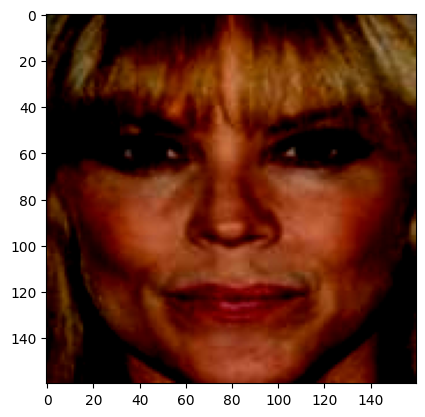

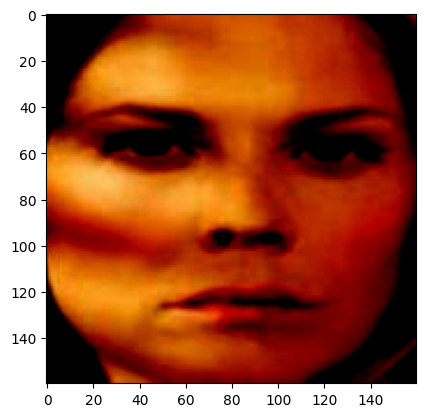

True


In [56]:
# x0, x1, y = ...
x0 = item0[0][0].permute(1,2,0) #dataset_train[0][0][0]
x1 = item0[0][1].permute(1,2,0) #dataset_train[0][0][1]
y = item0[1] #dataset_train[0][1]
x0.to(device)
x0.numpy()
x1.to(device)
x1.numpy()

plt.imshow(x0); plt.show();
plt.imshow(x1); plt.show();
print(y)
# plt.imshow(x0...); plt.show();
# plt.imshow(x1...); plt.show();

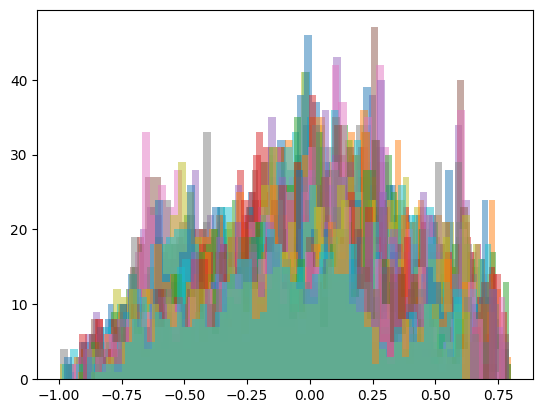

In [57]:
# We can also see that the images are properly normalized by displaying their histogram
plt.figure()
for chan in x0:
  plt.hist(chan.flatten(), bins=50, alpha=0.5)

We can now prepare the efficient loading and stream of dataset items using a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

#### ❓ Question

Try different values for batch_size and observe the effects on the shape of the elements yield by the DataLoader. Please note that bigger batch size can accelerate the processing. Also, at the end of this session, we will need to ensure that we have positive and negative samples in each batch (hence having a batch size >= 2 here).

**What happens?**

In [58]:
from torch.utils.data import DataLoader
loader_train = DataLoader(dataset_train, batch_size=40, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=2, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

In [59]:
# Check the output is correct
(x0, x1), y = next(iter(loader_train))
# You can display more information here if needed


In [62]:
print(x0.shape)
print(x1.shape)
print(y)

torch.Size([40, 3, 160, 160])
torch.Size([40, 3, 160, 160])
Fail to import hypothesis in common_utils, tests are not derandomized
tensor([ True, False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True, False])


We can also iterate over the elements of the DataLoader, much alike what will be used in a training loop.

In [63]:
for batch_ndx, sample in enumerate(loader_train):
    if batch_ndx > 2:  # Show the content of the first two batches only
        break
    print("Batch", batch_ndx)
    (sample), y = sample
    for ii, tensor in enumerate(sample):
        print("\t", ii, tensor.shape, tensor.dtype)
    print("\t", y.shape, y.dtype, y)
    print()

Batch 0
	 0 torch.Size([40, 3, 160, 160]) torch.float32
	 1 torch.Size([40, 3, 160, 160]) torch.float32
	 torch.Size([40]) torch.bool tensor([ True, False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True, False])

Batch 1
	 0 torch.Size([40, 3, 160, 160]) torch.float32
	 1 torch.Size([40, 3, 160, 160]) torch.float32
	 torch.Size([40]) torch.bool tensor([ True, False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True, False])

Batch 2
	 0 torch.Size([40, 3, 160, 160]) torch.float32
	 1 torch.Size([40, 3, 160, 160]) torch.float32


# Extract embeddings
Now we will apply a pre-trained facenet to obtain useful embeddings.

Using these embeddings, we'll be able to compare images quickly by measuring the similarity between these compact representations.

## Device placement
A very important thing to understand with PyTorch is where memory is stored and code executed.
Because we are using computation accelerators like GPU cards, we can explicitly move networks and variables (tensors) to different devices.

The [torch.Tensor](https://pytorch.org/docs/stable/tensors.html] and the [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) classes expose the following useful methods:

- [`.cpu()`](https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html#torch.Tensor.cpu) and [`.cuda()`](https://pytorch.org/docs/stable/generated/torch.Tensor.cuda.html#torch.Tensor.cuda) which are general copy-to-cpu or copy-to-cuda utilities
- [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to) which copies the object to a particular device

We will now inspect the available devices.

In [64]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Create a backbone

It is now time to create the useful network: a ResNet backbone which will be used to convert image data to a compact representation.

We define a factory function to create a new backbone, as we will create different architectures and do not want to share weights by accident between them: this is the case if we reuse a variable!

In [107]:
from facenet_pytorch import InceptionResnetV1
def new_backbone(device):
  return InceptionResnetV1(
    classify=False,
    pretrained='vggface2'
).to(device)

resnet = new_backbone(device)
# You can either print the object to see its structure
# or use some fancier display tool like https://github.com/szagoruyko/pytorchviz
# resnet

/opt/conda/lib/python3.10/site-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_file)

In [81]:
# print(resnet) #wow

## Make predictions with the backbone
Let's predict some embeddings with our network!

Warning! We need to feed it with tensors on the same device!

#### 🚧 TODO

**Choose an appropriate [similarity or distance function](https://pytorch.org/docs/stable/nn.html#distance-functions) to compare the two embeddings, and complete the code below to print for several pairs of the training set: the similarity score, and whether this sample is positive or negative (target).**

In [82]:
from torch import nn

In [87]:
# STUDENT
resnet.eval()  # disable layers like Dropout for simple inference
for batch_ndx, sample in enumerate(loader_train):
    if batch_ndx > 1:
        break
    (x0, x1), y = sample
    y = y.numpy()
    with torch.no_grad():
      # this part is frozen
      e0 = resnet(x0.to(device))
      e1 = resnet(x1.to(device))
      print("e0.shape", e0.shape)
    # select a similarity or distance function, and apply it to the two embeddings
    # https://pytorch.org/docs/stable/nn.html#distance-functions
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    d = cos(e0, e1).cpu().numpy()
    

    print("d.shape", d.shape)
for target, distance in zip(y, d):
  print(target, distance)

e0.shape torch.Size([40, 512])
d.shape (40,)
e0.shape torch.Size([40, 512])
d.shape (40,)
True 1.0359764
False 1.3149629
True 0.60759866
False 1.4489517
True 0.58169067
False 1.4025109
True 0.53095406
False 1.3773263
True 0.58839405
False 1.4111174
True 0.5232118
False 1.4167289
True 1.0782965
False 1.3553154
True 0.8156315
False 1.412045
True 0.64211494
False 1.4829324
True 0.49427804
False 1.3420337
True 0.74138206
False 1.5491014
True 1.1787784
False 1.3507421
True 0.64006615
False 1.5309144
True 0.4130394
False 1.430796
True 0.6617185
False 1.3359878
True 0.58165866
False 1.5373657
True 0.6532903
False 1.4241772
True 0.72196424
False 1.3847965
True 0.78413075
False 1.329117
True 0.68747276
False 1.3612176


#### ❓ Question

**Given the values you obtained, and the target prediction, does it seem possible to solve the problem?**

*Write your anwser here.*

# Siamese network 1: Independant classifier
We will now define a **Siamese network** to facilite our work.
This particular version will be used to **compute similarity scores between image pairs**, in order to **train/apply a simple binary classification on top of it**.

We will code several variants depending on the target use. In particular, we will play with two important things to accelerate our computations:

- disable gradient recording using the `with toch.no_grad()` context manager (you can learn more about [locally disabling gradient computation](https://pytorch.org/docs/stable/notes/autograd.html#locally-disabling-gradient-computation) in the documentation)
- enable or disable training mode with `.train()` or `.eval()` to change the behavior of several special layers like Dropout

As a rule of a thumb, if we **do not want to perform any training on a network**, we want to **disable gradient computation** and **run in evaluation mode**.

## Architecture definition

#### 🚧 TODO

**Complete the code of the classe below to create a frozen Siamese network.**

In [116]:
#STUDENT
class FrozenSiameseNet(nn.Module):
  def __init__(self, base_network):
    super().__init__()
    self.base_network = base_network
    # disable Dropout and others in the base network as it will be used for embedding only
    self.base_network.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    
    self.similarity = cos 
  def forward(self, x):
    # IMPORTANT: our network take a single input, but this input is a tuple with two tensors!
    x0, x1 = x
    e0, e1 = None, None
    with torch.no_grad():
      # no gradients here
      e0 = self.base_network(x0.to(device))
      e1 = self.base_network(x1.to(device))
    output = self.similarity(e0, e1)
    return output

In [117]:
# Let's create our network
sim_score_net = FrozenSiameseNet(new_backbone(device))

/opt/conda/lib/python3.10/site-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_file)

In [118]:
sim_score_net.eval();  # We won't perform any training on the particular network

## Compute similarities for each pair
By computing the score for each pair in the training set, we will be able to create a proper training set for a manual classifier!

In the code below, we:
1. define new variables to store the similarities and the associated expected decisions
2. run the network per batch to compute scores
3. extract the individual predictions for each sample of each batch

In [119]:
similarities = np.zeros(len(dataset_train), dtype=np.float32)
targets = np.zeros(len(dataset_train), dtype=bool)

sample_id = 0
for batch_ndx, sample in enumerate(loader_train):
    # if batch_ndx > 3:
    #     break
    if sample_id % 400 == 0:
      print(f"Batch {batch_ndx} ({sample_id} / {len(dataset_train)})")
    (x_pair), y = sample
    y = y.numpy()
    scores = None
    with torch.no_grad():  # optimization
      # Note how we send the input pairs to the device here!
      # ?? What is the shape of the scores variable below? Can you guess?
      scores = sim_score_net([xi.to(device) for xi in x_pair]).cpu().numpy()
    for distance, target in zip(scores, y):
      similarities[sample_id] = distance
      targets[sample_id] = target
      sample_id += 1
similarities.shape, targets.shape

Batch 0 (0 / 3200)
Batch 10 (400 / 3200)
Batch 20 (800 / 3200)
Batch 30 (1200 / 3200)
Batch 40 (1600 / 3200)
Batch 50 (2000 / 3200)
Batch 60 (2400 / 3200)
Batch 70 (2800 / 3200)


((3200,), (3200,))

In [176]:
print(similarities)

[ 0.7545076  -0.2568981   0.8311579  ...  0.15111864  0.72576374
  0.24390984]


#### ❓ Question

**What is the shape of the scores variable below? Can you guess?**

*Write your anwser here.*

OK, we got our data.

Let's analyse it to find a suitable threshold.


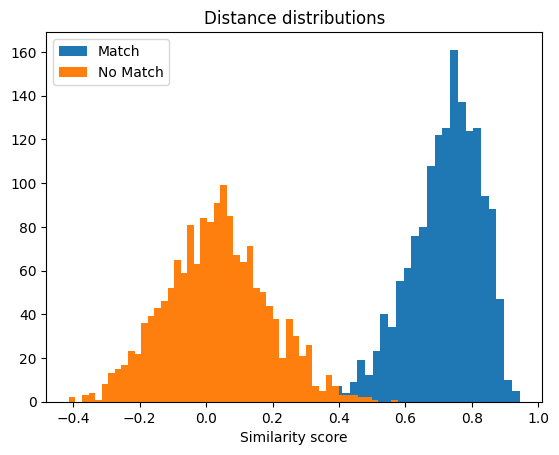

In [120]:
# Extract the score for positive and negative samples
score_match = similarities[targets]
score_diffe = similarities[~targets]
plt.hist(score_match, bins=50, label="Match")
plt.hist(score_diffe, bins=50, label="No Match")
plt.title("Distance distributions")
plt.xlabel("Similarity score")
plt.legend()
plt.show()

In practice for face verification we want very low FPR.  
The practice is to report TPR @ fixed FPR (like 0.01 or lower)

The code below show a very simple way to find an appropriate threshold.

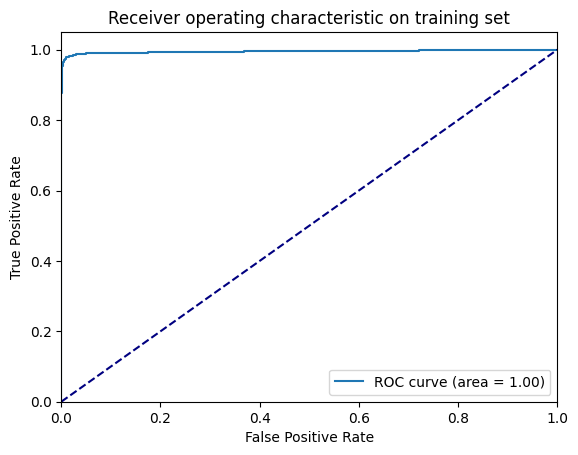

In [121]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(targets, similarities)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic on training set')
plt.legend(loc="lower right")
plt.show()

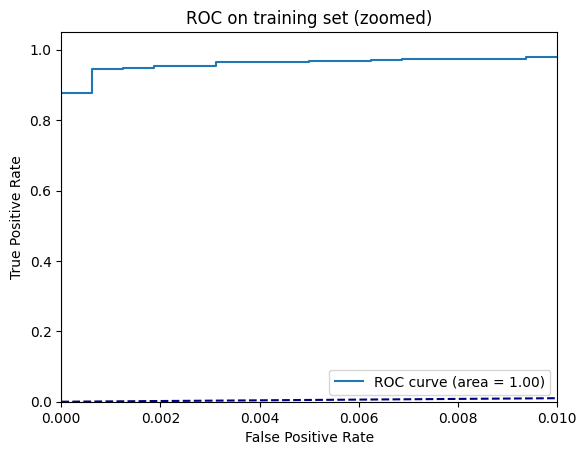

In [122]:
# Zoom in the interesting part:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 0.01])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on training set (zoomed)')
plt.legend(loc="lower right")
plt.show()

In [123]:
# Compute TPR and threshold to used to reach FPR=1%
ind = np.searchsorted(fpr, 0.01)
ind, tpr[ind], thresholds[ind]

(29, 0.97875, 0.38432318)

In [124]:
# Compute TPR and threshold to used to reach FPR=5%
ind = np.searchsorted(fpr, 0.05)
ind, tpr[ind], thresholds[ind]

(49, 0.98875, 0.29270625)

We see here that we loose true positives quite quickly when getting closer to FPR = 0.

For a threshold at 0.38, we get 1% FPR and 97.9% TPR: this seems acceptable for a non critical application.

## Simple classifier training
We know how to train simple classifiers: let's use scikit-learn!

#### 🚧 TODO
Using the `similarities` and `targets` variables previously defined, train a simple binary classified from scikit-learn and report its performance on the training set. You can also compute its performance on the validation set, but you will need to computes similarities and targets on this set too.

In [127]:
from sklearn.linear_model import LogisticRegression

In [170]:
clf = LogisticRegression()
clf.fit(similarities.reshape(-1,1), targets.reshape(-1,1))
clf.score(similarities.reshape(-1,1), targets.reshape(-1,1))

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9203125

# Siamese network 2: Contrastive loss

Let us now build another architecture with the exact same structure, but removing the optimization to re-enable the training of the internal weights of the backbone network.

Doing so, we will be able to leverage positive and negative examples from the training set with a custom loss function to optimize the representation for the final binary decision.

## Architecture definition

#### 🚧 TODO
**Complete the code below, based on your previous implementation, removing any optimization which prevents training.**

In [145]:
# We need to unfreeze the backbone
class SiameseNet(nn.Module):
  def __init__(self, base_network):
    super().__init__()
    self.base_network = base_network
    self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

  def forward(self, x):
    x0, x1 = x
    e0, e1 = None, None
    e0 = self.base_network(x0)
    e1 = self.base_network(x1)         

    sim_score = self.cos(e0, e1)

    # ???
    return sim_score

## Contrastive loss function

Here is a simple loss function we can implement. It can be implemented in a way we avoid for-loop and if/else.

$$L(y, \hat{y}) = y (1 - \hat{y})^2 + (1 - y) \operatorname{max}^2(\hat{y} - m, 0)$$

Where $\hat{y} \in [0,1]$ is the prediction (similarity score) and $y \in \{0,1\}$ is a boolean target.

In [147]:
def contrastive_loss(predictions_batch, targets_batch, margin=0.20):
  targets_batch = targets_batch.float()  # ensure we have floats here
  pos_pair = targets_batch * (1 - predictions_batch) #????
  neg_pair = (1 - targets_batch) * torch.clamp(predictions_batch - margin, min=0)

  pos_pair = pos_pair ** 2
  neg_pair = neg_pair ** 2

  # Note that `targets_batch` acts here as a gate to avoid doing a for-loop and if/else
  return torch.mean(pos_pair + neg_pair)

## Fine-tune the network

TODO

In [148]:
# Code to evaluate the model
def eval_model(net, loader, device):
  net.eval()
  acc, loss = 0., 0.
  c = 0
  for (x0, x1), gt_simi in loader:
    with torch.no_grad():
      pred_simi = net((x0.to(device), x1.to(device))).cpu()

    loss += contrastive_loss(pred_simi, gt_simi).item()
    # We define the accuracy according to an arbitratry threshold of 0.5.
    acc += ((pred_simi > 0.5).float() == gt_simi).sum().item()
    c += len(x0)

  acc /= c
  loss /= len(loader)
  net.train()
  return round(100 * acc, 2), round(loss, 5)



In [177]:
# TODO create a data loader for the validation set
dataset_val = CACDVSPairs("/content/datasets", split="val", download=True, transform=transform)
loader_val = DataLoader(dataset_val, batch_size=40, shuffle=False, num_workers=4)#???

Files already downloaded and verified


In [154]:
# Big training loop
import copy
net = SiameseNet(new_backbone(device)).to(device)
best_model, best_acc = None, 0.0

optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)  # low LR

val_acc, val_loss = eval_model(net, loader_val, device)
print(f"Random model --> Val loss: {val_loss}, val accuracy: {val_acc}")
epochs = 15
margin = 0.0  # no margin at beginning, possible to raise this later

for epoch in range(epochs):
  losses = 0

  for x, y in loader_train:
    x0, x1 = x
    x0, x1, y = x0.cuda(), x1.cuda(), y.cuda()

    optimizer.zero_grad()

    pred_simi = net((x0, x1))
    loss = contrastive_loss(pred_simi, y, margin=margin)
    loss.backward()
    optimizer.step()

    losses += loss.item()

  print(f"Epoch {epoch}: Train loss: {round(losses / len(loader_train), 5)}")

  val_acc, val_loss = eval_model(net, loader_val, device)
  print(f"\tVal loss: {val_loss}, val accuracy: {val_acc}")

  if best_acc <= val_acc:
    print("\tCheckpointing!")
    best_acc = val_acc
    best_model = copy.deepcopy(net)

Random model --> Val loss: 0.04986, val accuracy: 96.5
Epoch 0: Train loss: 0.16832
	Val loss: 0.13422, val accuracy: 76.0
	Checkpointing!
Epoch 1: Train loss: 0.15757
	Val loss: 0.09911, val accuracy: 80.75
	Checkpointing!
Epoch 2: Train loss: 0.10981
	Val loss: 0.09624, val accuracy: 80.0
Epoch 3: Train loss: 0.08061
	Val loss: 0.08277, val accuracy: 82.75
	Checkpointing!
Epoch 4: Train loss: 0.05938
	Val loss: 0.09397, val accuracy: 80.75
Epoch 5: Train loss: 0.04746
	Val loss: 0.09682, val accuracy: 81.25
Epoch 6: Train loss: 0.03743
	Val loss: 0.09025, val accuracy: 81.75
Epoch 7: Train loss: 0.02859
	Val loss: 0.07912, val accuracy: 82.5
Epoch 8: Train loss: 0.02186
	Val loss: 0.08112, val accuracy: 85.0
	Checkpointing!
Epoch 9: Train loss: 0.01559
	Val loss: 0.08678, val accuracy: 83.5
Epoch 10: Train loss: 0.01466
	Val loss: 0.09585, val accuracy: 83.0
Epoch 11: Train loss: 0.01232
	Val loss: 0.08721, val accuracy: 84.5
Epoch 12: Train loss: 0.0085
	Val loss: 0.08715, val accur

In [156]:
dataset_test = CACDVSPairs("/content/datasets", split="test", download=True, transform=transform)
loader_test = DataLoader(dataset_test, batch_size=40, shuffle=False, num_workers=4)#???

Files already downloaded and verified
No targets provided for test set, using default values.


In [160]:
predictions_test = sim_score_net(loader_test)

ValueError: too many values to unpack (expected 2)

In [ ]:
np.save("predictions_test.npy", predictions_test)

# Deliverable: process the test set

The test set has a hidden ground truth
You will need to process it by batchs, the trick used to compute the similarity scores for every pair can be reapplied here.
You output must be a file named `predictions_test.npy` and must contain a np array of shape (400, ) and dtype bool.
If you produced predictions_test.npy with `np.save("predictions_test.npy", predictions_test)`, then predictions_test[ii] must indicate whether the pair ii from the test set represents the same identity (True) or not (False)

**DON'T FORGET TO SUBMIT YOUR PREDICTIONS ON MOODLE!**

Also, visualize your predictions!


In [192]:
results = []
sample_id = 0
for batch_ndx, sample in enumerate(loader_test):
    (x_pair), y = sample
    y = y.numpy()
    scores = None
    with torch.no_grad():  # optimization
      scores = sim_score_net([xi.to(device) for xi in x_pair]).cpu().numpy()

      results.append(scores)
results = np.array(results).flatten()
print(results)

[ 7.54507601e-01 -2.56898105e-01  8.31157923e-01  7.18744040e-01
  2.43926458e-02 -6.26308024e-02  1.10490546e-01 -2.23964661e-01
  8.67896557e-01  6.06923625e-02  1.91421434e-03  1.93119615e-01
  8.44831109e-01  2.90780626e-02 -6.61086142e-02  3.19336474e-01
  9.28446930e-03  1.05984047e-01 -1.64821401e-01  6.59552515e-01
 -1.02599161e-02 -1.19196355e-01  6.05554134e-03 -7.27306157e-02
  6.04427695e-01  7.27562487e-01  7.87803650e-01  7.85030842e-01
  2.39107862e-01  6.81820869e-01  6.60309970e-01  2.10769445e-01
  2.02283084e-01  7.12180972e-01  2.06328183e-01  1.07692152e-01
  1.45882934e-01 -8.81726518e-02  7.24566817e-01  2.06011713e-01
  6.91922665e-01  4.63200919e-02  6.72618970e-02 -1.72784254e-02
  7.90033579e-01  7.60291219e-01  8.18668783e-01  8.03803921e-01
  7.35010132e-02  1.26264423e-01  5.48687100e-01  7.68130660e-01
  1.74927562e-01  7.62336850e-01  7.27081180e-01  8.07196736e-01
  8.76920104e-01  1.25355721e-02  3.57840210e-01  1.11598685e-01
  3.57510149e-01  8.33039

In [206]:
predictions_test = clf.predict(results.reshape(-1,1))
print(predictions_test.shape)

(400,)


In [200]:
    np.save("predictions_test.npy", predictions_test)

In [201]:
!ls

predictions_test.npy
